In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from utils.eval import score
from utils.models import CentroidSMOTE
from utils.models import KNNModel
from imblearn.over_sampling import SMOTE

# Reading, Preprocessing and EDA

In [3]:
Train_path = "../datasets/cencus_income/census-income.data"
Test_path = "../datasets/cencus_income/census-income.test"
train_df = pd.read_csv(Train_path, header = None)
test_df = pd.read_csv(Test_path, header = None)

In [4]:
print(train_df.shape, test_df.shape)

(199523, 42) (99762, 42)


This is our target variable. The income.

In [5]:
print(train_df[41].value_counts(), test_df[41].value_counts())

41
 - 50000.    187141
 50000+.      12382
Name: count, dtype: int64 41
 - 50000.    93576
 50000+.      6186
Name: count, dtype: int64


In [6]:
print(train_df.isnull().sum().sum(), test_df.isna().sum().sum())

0 0


It has null values, stored as '?' and has categorical columns too.

In [7]:
list_dtype = [train_df[i].dtype for i in train_df.columns]
print(dict((i, list_dtype.count(i)) for i in list_dtype))

list_dtype = [test_df[i].dtype for i in test_df.columns]
print(dict((i, list_dtype.count(i)) for i in list_dtype))

{dtype('int64'): 12, dtype('O'): 29, dtype('float64'): 1}
{dtype('int64'): 12, dtype('O'): 29, dtype('float64'): 1}


In [8]:
ch = train_df.iloc[11][32]
print(ch)
train_df = train_df.replace(ch, np.NaN)
test_df = test_df.replace(ch, np.NaN)

 ?


In [9]:
null = train_df.isnull().sum()
for i in range(len(null)):
    if null[i] > 0:
        print(i, null[i])

null = test_df.isnull().sum()
for i in range(len(null)):
    if null[i] > 0:
        print(i, null[i])

21 708
25 99696
26 99696
27 99696
29 99696
32 6713
33 6119
34 3393
21 330
25 49946
26 49946
27 49946
29 49946
32 3429
33 3072
34 1764


In [10]:
train_df = train_df.drop({25, 26, 27, 29}, axis = 1)
test_df = test_df.drop({25, 26, 27, 29}, axis = 1)

In [11]:
null = train_df.isnull().sum()
for i in null:
    if i > 0:
        print(i)
null = test_df.isnull().sum()
for i in null:
    if i > 0:
        print(i)

708
6713
6119
3393
330
3429
3072
1764


In [12]:
list_dtype = [train_df[i].dtype for i in train_df.columns]
print(dict((i, list_dtype.count(i)) for i in list_dtype))

{dtype('int64'): 12, dtype('O'): 25, dtype('float64'): 1}


In [13]:
for col in train_df.columns:
    if 'int' in train_df[col] or 'float' in train_df[col]:
        train_df[col] = train_df[col].fillna(train_df[col].mean())
        test_df[col] = test_df[col].fillna(train_df[col].mean())
    else:
        mode_val = train_df[col].mode()[0]
        train_df[col] = train_df[col].fillna(mode_val)
        test_df[col] = test_df[col].fillna(mode_val)

In [14]:
null = train_df.isnull().sum()
for i in null:
    if i > 0:
        print(i)

null = test_df.isnull().sum()
for i in null:
    if i > 0:
        print(i)

All missing values handled

In [15]:
print(train_df[41].value_counts(), test_df[41].value_counts())

41
 - 50000.    187141
 50000+.      12382
Name: count, dtype: int64 41
 - 50000.    93576
 50000+.      6186
Name: count, dtype: int64


In [16]:
label_encoder = LabelEncoder()
i = 41
train_df[i] = label_encoder.fit_transform(train_df[i])    
test_df[i] = label_encoder.transform(test_df[i])

In [17]:
combined_df = pd.concat([train_df, test_df])
combined_df = pd.get_dummies(combined_df)
print(combined_df[i].value_counts())
train_df = combined_df[:len(train_df)]
test_df = combined_df[len(train_df):]

41
0    280717
1     18568
Name: count, dtype: int64


In [18]:
train_df.columns = train_df.columns.astype(str)
test_df.columns = test_df.columns.astype(str)

In [19]:
print(train_df['41'].value_counts())
print(test_df['41'].value_counts())

41
0    187141
1     12382
Name: count, dtype: int64
41
0    93576
1     6186
Name: count, dtype: int64


In [20]:
# Separate the features and target variable
X_train = train_df.drop(['41'], axis=1)
X_test = test_df.drop(['41'], axis=1)
y_train = train_df['41']
y_test = test_df['41']

# Initialize and fit the scaler to the training data
scl = StandardScaler()
scl.fit(X_train)

# Transform the training and testing data using the scaler
X_train_scaled = scl.transform(X_train)
X_test_scaled = scl.transform(X_test)

# Create new dataframes with the scaled data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [21]:
pipeline = Pipeline([
    ('classifier', KNeighborsClassifier(metric='euclidean'))
])

parameters = {
    'classifier__n_neighbors' : [3, 5, 7, 9, 11],
}

In [22]:
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.944528
Error Rate: 0.05547202341572943
Precision: 0.795206
Recall: 0.616937
F1-score: 0.661507
Selectivity: 0.616937
Balanced Accuracy: 0.616937
Geometric Mean: 0.616937


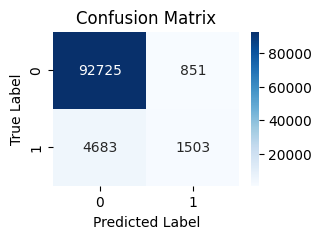

In [23]:
clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)
score(X_test, y_test, best_clf)

Resampled dataset shape Counter({0: 187141, 1: 187141})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.868918
Error Rate: 0.1310819751007397
Precision: 0.615978
Recall: 0.746095
F1-score: 0.645643
Selectivity: 0.746095
Balanced Accuracy: 0.746095
Geometric Mean: 0.746095


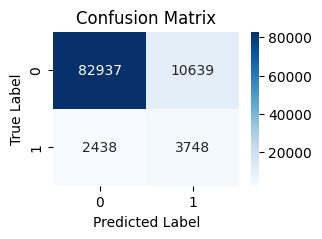

Resampled dataset shape Counter({0: 187141, 1: 187141})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.862824
Error Rate: 0.13717648002245342
Precision: 0.614444
Recall: 0.756132
F1-score: 0.643789
Selectivity: 0.756132
Balanced Accuracy: 0.756132
Geometric Mean: 0.756132


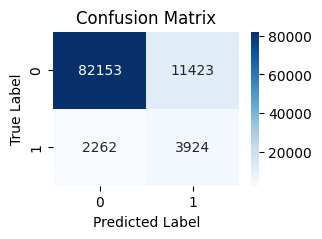

Resampled dataset shape Counter({0: 187141, 1: 187141})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.858744
Error Rate: 0.14125618973156107
Precision: 0.613235
Recall: 0.761581
F1-score: 0.642059
Selectivity: 0.761581
Balanced Accuracy: 0.761581
Geometric Mean: 0.761581


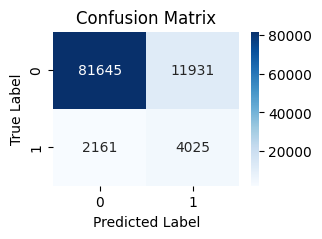

Resampled dataset shape Counter({0: 187141, 1: 187141})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.855857
Error Rate: 0.14414306048395176
Precision: 0.612535
Recall: 0.765704
F1-score: 0.640942
Selectivity: 0.765704
Balanced Accuracy: 0.765704
Geometric Mean: 0.765704


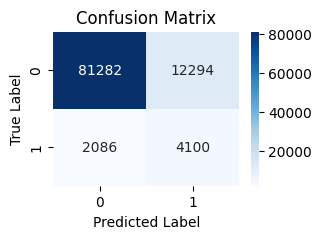

Resampled dataset shape Counter({0: 187141, 1: 187141})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.855747
Error Rate: 0.14425332290852233
Precision: 0.613948
Recall: 0.771080
F1-score: 0.642805
Selectivity: 0.771080
Balanced Accuracy: 0.771080
Geometric Mean: 0.771080


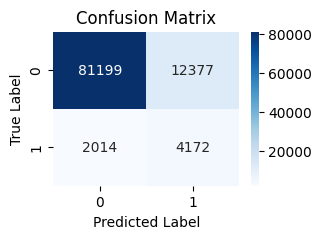

In [24]:
sm_list = []
from collections import Counter
for i in [3, 5, 7, 9, 11]:
    sm_list.append(SMOTE(random_state=42, k_neighbors=i))
for sm in sm_list:
    X_new, y_new = sm.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_new))
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.865119
Error Rate: 0.13488101682003173
Precision: 0.616503
Recall: 0.757657
F1-score: 0.646557
Selectivity: 0.757657
Balanced Accuracy: 0.757657
Geometric Mean: 0.757657


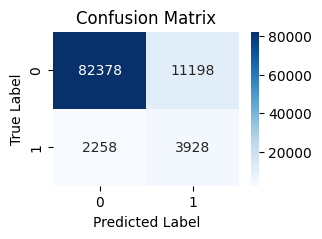

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.856539
Error Rate: 0.14346143822297064
Precision: 0.613150
Recall: 0.766369
F1-score: 0.641810
Selectivity: 0.766369
Balanced Accuracy: 0.766369
Geometric Mean: 0.766369


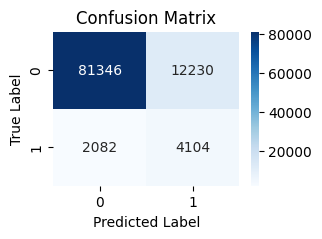

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.852729
Error Rate: 0.14727050379904172
Precision: 0.612087
Recall: 0.771057
F1-score: 0.640055
Selectivity: 0.771057
Balanced Accuracy: 0.771057
Geometric Mean: 0.771057


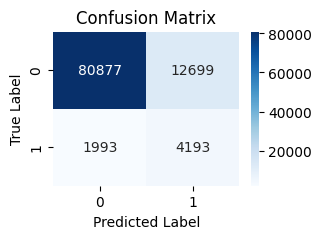

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.869449
Error Rate: 0.13055071069144564
Precision: 0.619507
Recall: 0.756871
F1-score: 0.650457
Selectivity: 0.756871
Balanced Accuracy: 0.756871
Geometric Mean: 0.756871


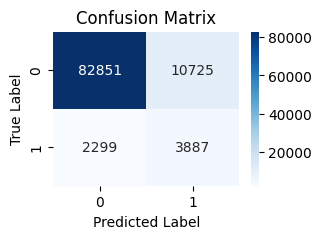

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.876877
Error Rate: 0.1231230328181071
Precision: 0.623476
Recall: 0.749507
F1-score: 0.654984
Selectivity: 0.749507
Balanced Accuracy: 0.749507
Geometric Mean: 0.749507


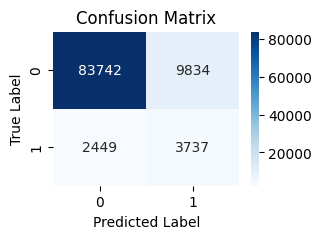

In [25]:
csm_list = []
for (i,j) in [(5,3), (7,3), (9,3), (7,5), (9,7)]:
    csm_list.append(CentroidSMOTE(k_neighbors=i, m_vertices=j))

for csm in csm_list:
    X_new, y_new = csm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)